In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')
sys.path.append('./SALSA-CLRS/')

import torch
from model.GINE import GINE

from loguru import logger
from baselines.core.models.encoder import Encoder
from baselines.core.models.decoder import Decoder
from baselines.core.loss import CLRSLoss
from salsaclrs import specs

device = torch.device('cuda')

lr = 0.001
eta = 0.001
weight_decay = 0.1

Ks = [10, 25, 50, 100, 250, 500, 1000, 1500, 2000, 2500, 3000]

c:\Users\heje197\AppData\Local\miniconda3\envs\minar\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\heje197\AppData\Local\miniconda3\envs\minar\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
from EncodeProcessDecode import EncodeProcessDecode
algorithms = ['bfs', 'dfs', 'dijkstra', 'mst_prim', 'bellman_ford', 'articulation_points', 'bridges']
output_types = {
    'bfs' : 'pointer',
    'dfs' : 'pointer',
    'dijkstra' : 'pointer',
    'mst_prim' : 'pointer',
    'bellman_ford' : 'pointer',
    'articulation_points' : 'mask',
    'bridges' : 'pointer',
}
logger.disable('baselines.core.models.encoder')
logger.disable('baselines.core.models.decoder')

hidden_dim = 128
encoders = torch.nn.ModuleDict({
    task : Encoder(specs=specs.SPECS[task]) for task in algorithms
})

decoders = torch.nn.ModuleDict({
    task : Decoder(specs=specs.SPECS[task], 
                   hidden_dim = hidden_dim * 2,
                   no_hint=False) for task in algorithms
})

for encoder in encoders.values():
    encoder.to(device)
for decoder in decoders.values():
    decoder.to(device)
processor = GINE(3*128, 128, 2, 128, edge_dim=1, aggr='max')
processor.to(device)
model = EncodeProcessDecode(encoders, decoders, processor, device=device)

model_checkpoint = f'distributed_GINE_l1_schedule_lr={lr}_eta={eta}_weight_decay={weight_decay}_batch_size=32_seed=0/model_best.pt'
model_state = torch.load(f'checkpoints/{model_checkpoint}', map_location=device)
model.load_state_dict(model_state)
model.eval()
model.to(device)

EncodeProcessDecode(
  (encoders): ModuleDict(
    (bfs): Encoder(
      (encoder): ModuleDict(
        (pos): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (s): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
      )
    )
    (dfs): Encoder(
      (encoder): ModuleDict(
        (pos): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
      )
    )
    (dijkstra): Encoder(
      (encoder): ModuleDict(
        (pos): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (s): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
      )
    )
    (mst_prim): Encoder(
      (encoder): ModuleDict(
        (pos): NodeBaseEncoder(
          (lin): Linear(in_features=1, out_features=128, bias=True)
        )
        (s): NodeBaseEncoder(
          (lin): Li

In [3]:
clean_directory = './data_clean/'
corrupted_directory = './data_corrupted/'

num_samples = 128
clean_data = {algorithm : [torch.load(f'{clean_directory}/{algorithm}/data_{i}.pt', weights_only=False) for i in range(num_samples)] for algorithm in algorithms}
corrupted_data = {algorithm : [torch.load(f'{corrupted_directory}/{algorithm}/data_{i}.pt', weights_only=False) for i in range(num_samples)] for algorithm in algorithms}
criteria = {algorithm : CLRSLoss(specs=specs.SPECS[algorithm], hidden_loss_type='l2') for algorithm in algorithms}

In [4]:
import os
from SALSACLRSComputationGraph import SALSACLRSComputationGraph
import networkx as nx
compute_scores = ['weight_grad', 'EAP', 'EAP-IG']

G = SALSACLRSComputationGraph(model, special_modules=['convs.0.lin', 'convs.1.lin'])
G.add_module('convs.0.lin', processor.convs[0].lin,
            module_inputs='edge_attr',
            module_outputs=0,
            layer=0)
G.add_module('convs.1.lin', processor.convs[1].lin,
            module_inputs='edge_attr',
            module_outputs=2,
            layer=0)
G.correct_layers()
print(G.number_of_edges())

G_save_string = f'G_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt'
if os.path.exists(f'scored_computation_graphs/{G_save_string}'):
    G_scores = torch.load(f'scored_computation_graphs/{G_save_string}', weights_only=False)
    for edge, data in G_scores.items():
        G.add_edge(*edge, **data)
    print(f'Loaded existing scored computation graph from scored_computation_graphs/{G_save_string}')
else:
    print('Creating new computation graph...')
    for algorithm in algorithms:
        for score_method in compute_scores:
            if score_method == 'EAP-IG':
                print(f'Calculating {score_method} scores for {algorithm}...')
                G.calculate_scores(algorithm, clean_data[algorithm], corrupted_data[algorithm], criteria[algorithm], which=score_method, **{'steps': 20})
            else:
                print(f'Calculating {score_method} scores for {algorithm}...')
                G.calculate_scores(algorithm, clean_data[algorithm], corrupted_data[algorithm], criteria[algorithm], which=score_method)

    # Only save the scores since saving the whole objects pickles the model
    G_scores = {(u,v) : data for u, v, data in G.edges(data=True)}
    torch.save(G_scores, f'scored_computation_graphs/{G_save_string}')

99712
Loaded existing scored computation graph from scored_computation_graphs/G_scores_lr=0.001_eta=0.001_weight_decay=0.1.pt


In [5]:
from SALSACLRSComputationGraph import SALSACLRSCircuit

score_methods = ['weight', 'weight_grad', 'EAP', 'EAP-IG']
circuit_path = f'salsa_clrs_circuits_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt'
if os.path.exists(f'circuits/{circuit_path}'):
    circuits = torch.load(f'circuits/{circuit_path}', weights_only=False)
else:
    circuits = {}
for K in Ks:
    skipped = False
    if circuits.get(('bridges', K, 'weight')) is None:
        weight_circuit = SALSACLRSCircuit(model, G, K, key='weight')
    for algorithm in algorithms:
        for score_method in score_methods:
            if (algorithm, K, score_method) in circuits:
                print(f'Circuit for {algorithm} with K={K} and score method {score_method} already exists. Skipping...')
                skipped = True
            elif score_method == 'weight':
                circuits[(algorithm, K, score_method)] = weight_circuit
                print(f'{algorithm} circuit with K={K} and score method {score_method}: {circuits[(algorithm, K, score_method)].number_of_edges()} edges')
            else:
                circuits[(algorithm, K, score_method)] = SALSACLRSCircuit(model, G, K, key=f'{score_method}_{algorithm}')
                print(f'{algorithm} circuit with K={K} and score method {score_method}: {circuits[(algorithm, K, score_method)].number_of_edges()} edges')
    for circuit in circuits.values():
        circuit.G = None
        circuit.model = None
        circuit.EncodeProcessDecode = None
    if not skipped:
        torch.save(circuits, f'circuits/{circuit_path}')
for circuit in circuits.values():
    circuit.G = G
    circuit.EncodeProcessDecode = model
    circuit.model = processor

Circuit for bfs with K=10 and score method weight already exists. Skipping...
Circuit for bfs with K=10 and score method weight_grad already exists. Skipping...
Circuit for bfs with K=10 and score method EAP already exists. Skipping...
Circuit for bfs with K=10 and score method EAP-IG already exists. Skipping...
Circuit for dfs with K=10 and score method weight already exists. Skipping...
Circuit for dfs with K=10 and score method weight_grad already exists. Skipping...
Circuit for dfs with K=10 and score method EAP already exists. Skipping...
Circuit for dfs with K=10 and score method EAP-IG already exists. Skipping...
Circuit for dijkstra with K=10 and score method weight already exists. Skipping...
Circuit for dijkstra with K=10 and score method weight_grad already exists. Skipping...
Circuit for dijkstra with K=10 and score method EAP already exists. Skipping...
Circuit for dijkstra with K=10 and score method EAP-IG already exists. Skipping...
Circuit for mst_prim with K=10 and sco

In [6]:
import itertools
jaccard_indices = {}
intersections = {}
for alg1, alg2 in itertools.product(algorithms, repeat=2):
    for score_method in compute_scores:
        for K in Ks:
            circuit1_edges = set(circuits[(alg1, K, score_method)].edges)
            circuit2_edges = set(circuits[(alg2, K, score_method)].edges)
            intersection = circuit1_edges & circuit2_edges
            union = circuit1_edges | circuit2_edges
            intersections[(alg1, alg2, K)] = intersection
            union_score = sum([abs(G.edges[edge].get('weight')) for edge in union])
            intersection_score = sum([abs(G.edges[edge].get('weight')) for edge in intersection])
            jaccard_index = float(intersection_score / union_score if union_score > 0 else 0)
            jaccard_indices[(alg1, alg2, K, score_method)] = jaccard_index
            if alg1 != alg2:
                print(f"{alg1} ∩ {alg2} at K={K}: {len(intersection)} edges, Jaccard Index: {jaccard_index:.4f}")

bfs ∩ dfs at K=10: 1 edges, Jaccard Index: 0.0078
bfs ∩ dfs at K=25: 2 edges, Jaccard Index: 0.0085
bfs ∩ dfs at K=50: 4 edges, Jaccard Index: 0.0062
bfs ∩ dfs at K=100: 16 edges, Jaccard Index: 0.0771
bfs ∩ dfs at K=250: 43 edges, Jaccard Index: 0.1584
bfs ∩ dfs at K=500: 99 edges, Jaccard Index: 0.1978
bfs ∩ dfs at K=1000: 225 edges, Jaccard Index: 0.2539
bfs ∩ dfs at K=1500: 348 edges, Jaccard Index: 0.2855
bfs ∩ dfs at K=2000: 517 edges, Jaccard Index: 0.3075
bfs ∩ dfs at K=2500: 709 edges, Jaccard Index: 0.3145
bfs ∩ dfs at K=3000: 898 edges, Jaccard Index: 0.3222
bfs ∩ dfs at K=10: 0 edges, Jaccard Index: 0.0000
bfs ∩ dfs at K=25: 2 edges, Jaccard Index: 0.0686
bfs ∩ dfs at K=50: 4 edges, Jaccard Index: 0.0798
bfs ∩ dfs at K=100: 6 edges, Jaccard Index: 0.0868
bfs ∩ dfs at K=250: 26 edges, Jaccard Index: 0.0802
bfs ∩ dfs at K=500: 78 edges, Jaccard Index: 0.1531
bfs ∩ dfs at K=1000: 237 edges, Jaccard Index: 0.2167
bfs ∩ dfs at K=1500: 412 edges, Jaccard Index: 0.2393
bfs ∩ dfs a

<Figure size 640x480 with 0 Axes>

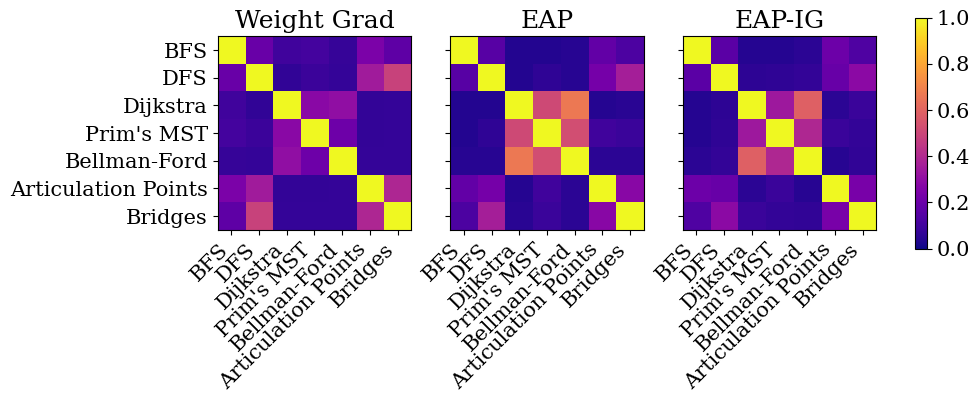

In [19]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

K_plot = 500
algorithms_plotting = ['BFS', 'DFS', 'Dijkstra', 'Prim\'s MST', 'Bellman-Ford', 'Articulation Points', 'Bridges']
score_methods_plotting = ['Weight', 'Weight Grad', 'EAP', 'EAP-IG']
plt.rcParams.update({'font.size': 15, 'font.family': 'serif'})
plt.set_cmap('plasma')
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
for i, score in enumerate(compute_scores):
    ax[i].imshow([[jaccard_indices.get((alg1, alg2, K_plot, score)) for alg2 in algorithms] for alg1 in algorithms], vmin=0, vmax=1.0)
    ax[i].set_title(score_methods_plotting[i+1]) # skip weight because they are all the same
    ax[i].set_xticks(range(len(algorithms)))
    ax[i].set_yticks(range(len(algorithms)))
    ax[i].set_xticklabels(algorithms_plotting, rotation=45, ha='right')
    ax[i].set_yticklabels(algorithms_plotting)
fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=1.0)), ax=ax, orientation='vertical', fraction=.1)
# plt.tight_layout()
plt.savefig(f'figures/jaccard_indices_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}_K={K_plot}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/jaccard_indices_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}_K={K_plot}.pdf', bbox_inches='tight')
plt.show()

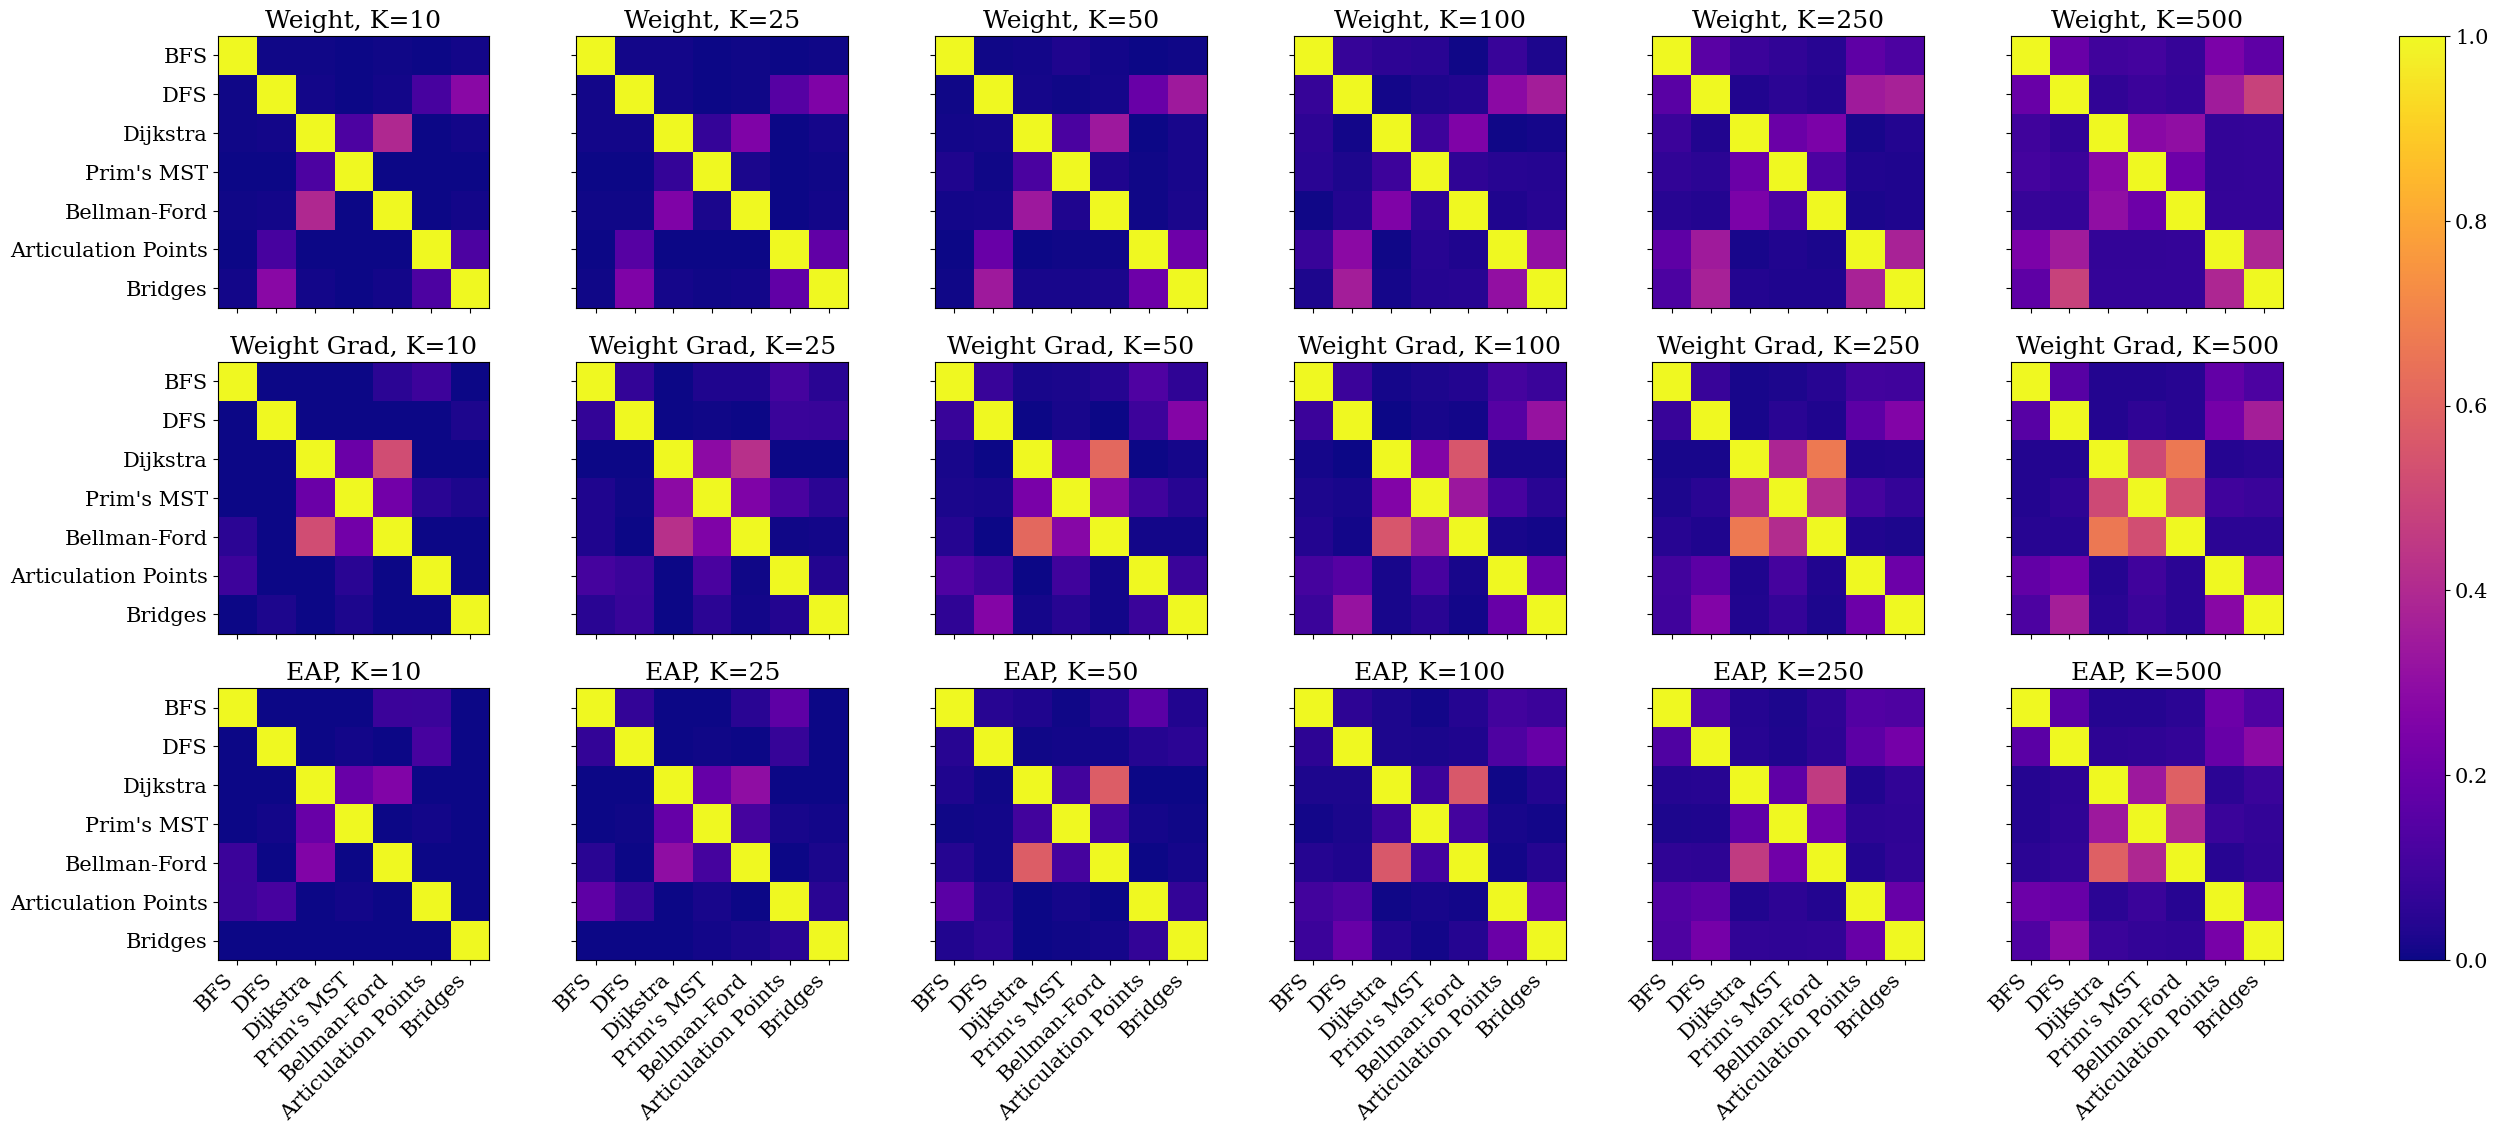

In [16]:
K_cutoff = 6
fig, ax = plt.subplots(len(compute_scores), K_cutoff, figsize=(5*K_cutoff, 4*len(compute_scores)), sharey=True, sharex=True)
for i, score_method in enumerate(compute_scores):
    for j, K in enumerate(Ks[:K_cutoff]):
        ax[i, j].imshow([[jaccard_indices.get((alg1, alg2, K, score_method)) for alg2 in algorithms] for alg1 in algorithms], vmin=0, vmax=1.0)
        ax[i, j].set_title(f'{score_methods_plotting[i]}, K={K}')
        ax[i, j].set_xticks(range(len(algorithms)))
        ax[i, j].set_yticks(range(len(algorithms)))
        ax[i, j].set_xticklabels(algorithms_plotting, rotation=45, ha='right')
        ax[i, j].set_yticklabels(algorithms_plotting)
fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=1.0)), ax=ax, orientation='vertical', fraction=.05)
# plt.tight_layout()
plt.savefig(f'figures/jaccard_indices_all_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}_1.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/jaccard_indices_all_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}_1.pdf', bbox_inches='tight')
plt.show()

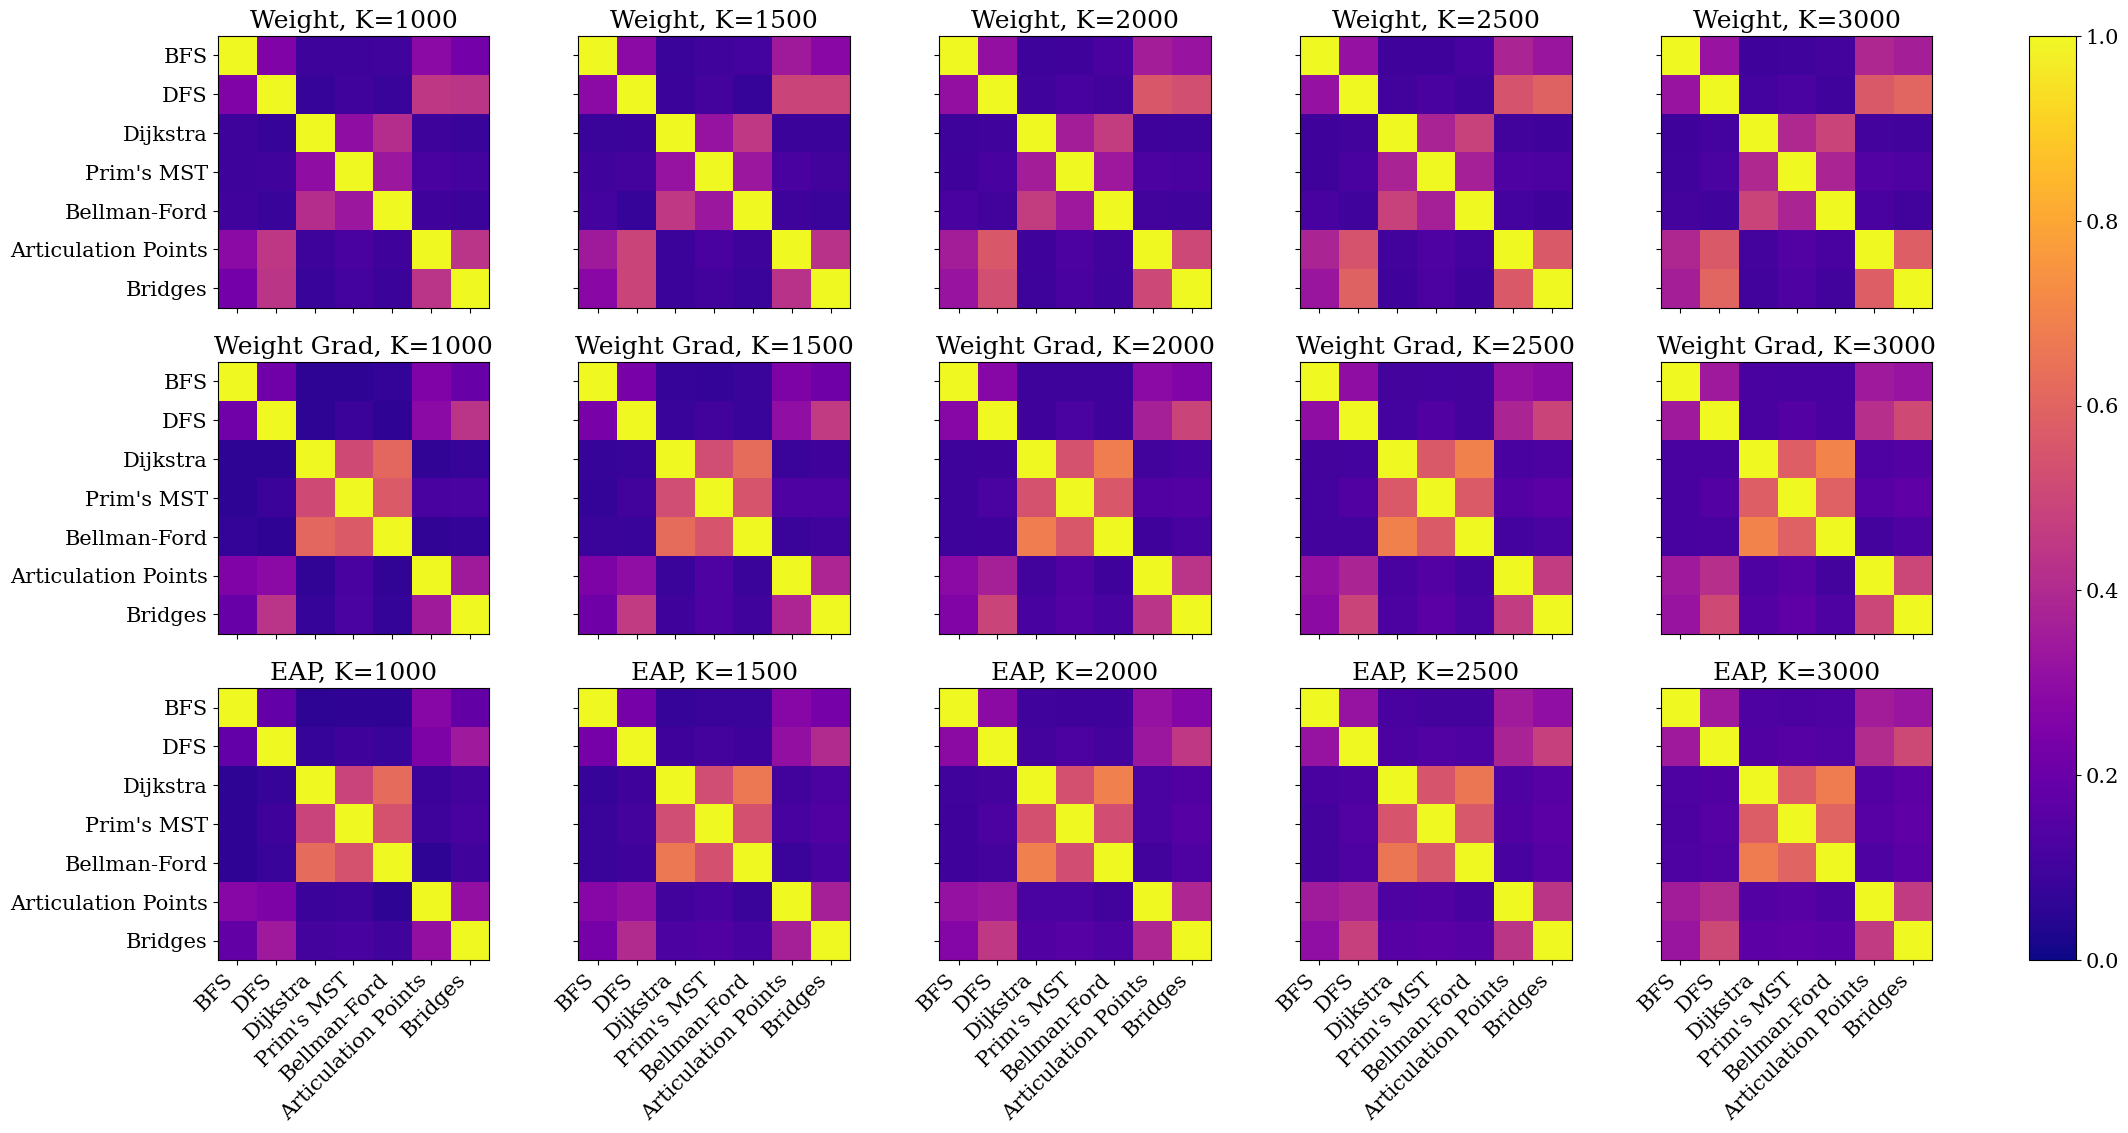

In [17]:
fig, ax = plt.subplots(len(compute_scores), len(Ks[K_cutoff:]), figsize=(5*len(Ks[K_cutoff:]), 4*len(compute_scores)), sharey=True, sharex=True)
for i, score_method in enumerate(compute_scores):
    for j, K in enumerate(Ks[K_cutoff:]):
        ax[i, j].imshow([[jaccard_indices.get((alg1, alg2, K, score_method)) for alg2 in algorithms] for alg1 in algorithms], vmin=0, vmax=1.0)
        ax[i, j].set_title(f'{score_methods_plotting[i]}, K={K}')
        ax[i, j].set_xticks(range(len(algorithms)))
        ax[i, j].set_yticks(range(len(algorithms)))
        ax[i, j].set_xticklabels(algorithms_plotting, rotation=45, ha='right')
        ax[i, j].set_yticklabels(algorithms_plotting)
fig.colorbar(plt.cm.ScalarMappable(cmap='plasma', norm=plt.Normalize(vmin=0, vmax=1.0)), ax=ax, orientation='vertical', fraction=.05)
# plt.tight_layout()
plt.savefig(f'figures/jaccard_indices_all_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}_2.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/jaccard_indices_all_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}_2.pdf', bbox_inches='tight')
plt.show()

In [25]:
# Get model baseline performance and embeddings
from salsaclrs.data import SALSACLRSDataLoader
from baselines.core.metrics import calc_metrics

try:
    acc_model = torch.load(f'metrics/acc_model_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
except:
    acc_model = {}
    for task in algorithms:
        loader = SALSACLRSDataLoader(clean_data[task], batch_size=32, shuffle=False, device=model.device)
        avg_model_acc = 0
        for data in loader:
            data.to(model.device)
            if hasattr(data, 'weights'):
                data.edge_attr = data.weights.unsqueeze(1)
            else:
                data.edge_attr = torch.zeros((data.num_edges, 1), device=model.device)
            data.task = task
            out, _, hidden = model(data)
            model_accuracy = calc_metrics(data.outputs[0], out, data, output_types[task])['node_accuracy'].mean().item()
            avg_model_acc += model_accuracy / len(loader)
        acc_model[task] = avg_model_acc
    torch.save(acc_model, f'metrics/acc_model_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')

In [26]:
from salsaclrs.data import SALSACLRSDataLoader
from baselines.core.metrics import calc_metrics

try:
    acc_model = torch.load(f'metrics/acc_model_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
    acc_circuit = torch.load(f'metrics/acc_circuit_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
    acc_ablate = torch.load(f'metrics/acc_ablate_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
    fid_circuit = torch.load(f'metrics/fid_circuit_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
    fid_ablate = torch.load(f'metrics/fid_ablate_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt', weights_only=False)
except:
    acc_model = {}
    acc_circuit = {}
    acc_ablate = {}
    fid_circuit = {}
    fid_ablate = {}

batch_size = 32
for task in algorithms:
    print(f'Calculating metrics for {task}...')
    loader = SALSACLRSDataLoader(clean_data[task], batch_size=batch_size, shuffle=False)
    for score_method in score_methods:
        for K in Ks:
            if (task, K, score_method) in acc_circuit:
                print(f'Metrics for {task} with K={K} and score method {score_method} already exists. Skipping...')
                continue
            circuit = circuits[(task, K, score_method)]
            avg_acc_circuit = 0
            avg_acc_ablate = 0
            avg_fid_circuit = 0
            avg_fid_ablate = 0
            for data in loader:
                data.to(device)
                if hasattr(data, 'weights'):
                    data.edge_attr = data.weights.unsqueeze(1)
                else:
                    data.edge_attr = torch.zeros((data.num_edges, 1), device=device)
                data.task = task

                # Original model
                out_model, _, _ = model(data)
                # Circuit model
                out_circuit, _, _ = circuit.forward(data)
                circuit_accuracy = calc_metrics(data.outputs[0], out_circuit, data, output_types[task])['node_accuracy'].mean().item()
                # Ablated circuit model
                out_ablate, _, _ = circuit.ablate_circuit(data)
                ablate_accuracy = calc_metrics(data.outputs[0], out_ablate, data, output_types[task])['node_accuracy'].mean().item()

                data_compare = data.clone()
                for output in data_compare.outputs:
                    if task == 'articulation_points':
                        data_compare.outputs = out_model[output].detach() > 0
                    else:
                        data_compare.outputs = out_model[output].detach()
                circuit_fid = calc_metrics(data.outputs[0], out_circuit, data_compare, output_types[task])['node_accuracy'].mean().item()
                ablate_fid = calc_metrics(data.outputs[0], out_ablate, data_compare, output_types[task])['node_accuracy'].mean().item()

                avg_acc_circuit += circuit_accuracy
                avg_acc_ablate += ablate_accuracy
                avg_fid_circuit += circuit_fid
                avg_fid_ablate += ablate_fid

            circuit_accs = avg_acc_circuit / len(loader)
            ablate_accs = avg_acc_ablate / len(loader)
            circuit_fids = 1 - avg_fid_circuit / len(loader)
            ablate_fids = 1 - avg_fid_ablate / len(loader)

            print(f'Task: {task}, K: {K}, Score: {score_method} | Circuit Acc: {circuit_accs:.4f}, Ablate Acc: {ablate_accs:.4f}, Circuit Fid: {circuit_fids:.6f}, Ablate Fid: {ablate_fids:.6f}')
            acc_circuit[(task, K, score_method)] = circuit_accs
            acc_ablate[(task, K, score_method)] = ablate_accs
            fid_circuit[(task, K, score_method)] = circuit_fids
            fid_ablate[(task, K, score_method)] = ablate_fids
torch.save(acc_model, f'metrics/acc_model_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')
torch.save(acc_circuit, f'metrics/acc_circuit_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')
torch.save(acc_ablate, f'metrics/acc_ablate_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')
torch.save(fid_circuit, f'metrics/fid_circuit_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')
torch.save(fid_ablate, f'metrics/fid_ablate_lr={lr}_eta={eta}_weight_decay={weight_decay}.pt')

Calculating metrics for bfs...
Metrics for bfs with K=10 and score method weight already exists. Skipping...
Metrics for bfs with K=25 and score method weight already exists. Skipping...
Metrics for bfs with K=50 and score method weight already exists. Skipping...
Metrics for bfs with K=100 and score method weight already exists. Skipping...
Metrics for bfs with K=250 and score method weight already exists. Skipping...
Metrics for bfs with K=500 and score method weight already exists. Skipping...
Metrics for bfs with K=1000 and score method weight already exists. Skipping...
Metrics for bfs with K=1500 and score method weight already exists. Skipping...
Metrics for bfs with K=2000 and score method weight already exists. Skipping...
Metrics for bfs with K=2500 and score method weight already exists. Skipping...
Metrics for bfs with K=3000 and score method weight already exists. Skipping...
Metrics for bfs with K=10 and score method weight_grad already exists. Skipping...
Metrics for bfs

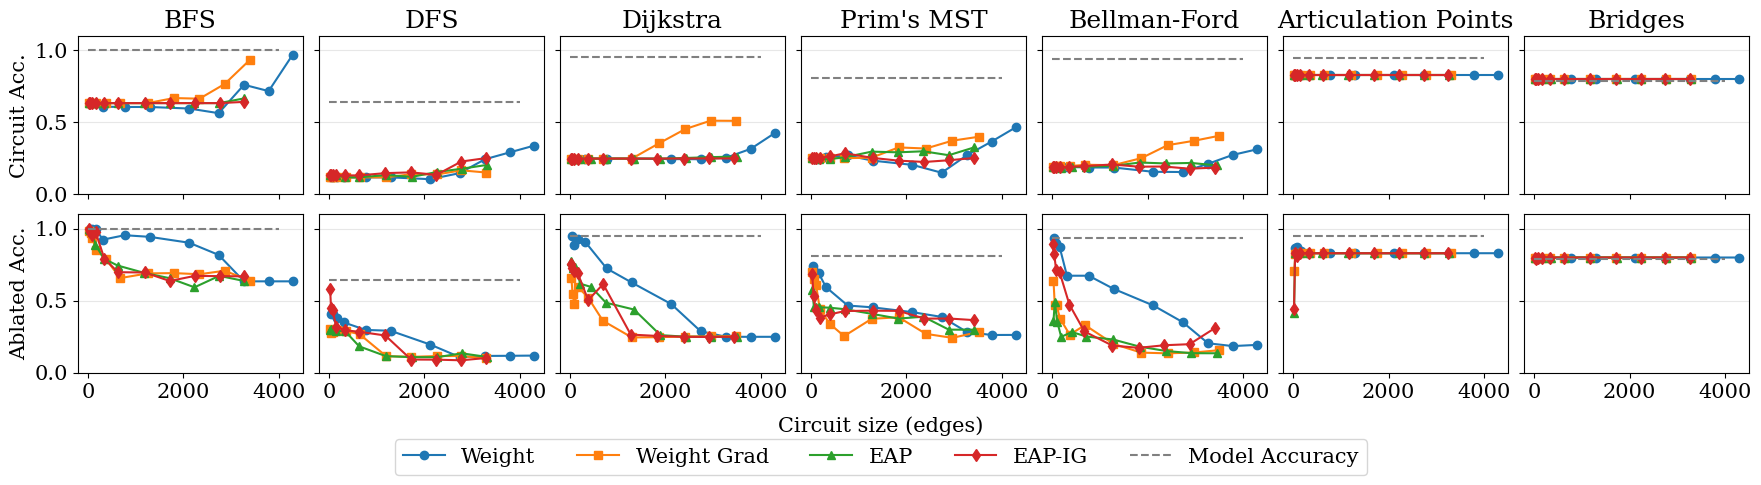

In [ ]:
tasks = algorithms
Ks_list = Ks
ticks = range(0, 5000, 1000)
tick_labels = [f'{i}K' for i in range(0, 5)]
cols = len(tasks)
rows = 2
score_markers = ['o', 's', '^', 'd']
fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 4), constrained_layout=True, sharex=True, sharey=True)
for i, task in enumerate(tasks):
    ax_c = axes[0][i]
    ax_a = axes[1][i]
    for score_method, score_plot, marker in zip(score_methods, score_methods_plotting, score_markers):
        x = [circuits[(task, K, score_method)].number_of_edges() for K in Ks_list]

        y_c = [float(acc_circuit.get((task, K, score_method), float('nan'))) for K in Ks_list]
        ax_c.plot(x, y_c, marker=marker, label=score_plot)
        y_a = [float(acc_ablate.get((task, K, score_method), float('nan'))) for K in Ks_list]
        ax_a.plot(x, y_a, marker=marker, label=score_plot)

    ax_c.hlines(y=acc_model[task], xmin=0, xmax=max(ticks), colors='gray', linestyles='dashed', label='Model Accuracy')
    ax_a.hlines(y=acc_model[task], xmin=0, xmax=max(ticks), colors='gray', linestyles='dashed', label='Model Accuracy')

    ax_c.set_title(algorithms_plotting[i])
    if i == 0:
        ax_c.set_ylabel('Circuit Acc.')
        ax_a.set_ylabel('Ablated Acc.')
    ax_c.grid(axis='y', alpha=0.3)
    ax_c.set_ylim(0, 1.1)
    ax_a.grid(axis='y', alpha=0.3)
    ax_a.set_ylim(0, 1.1)

fig.text(0.5, -0.05, 'Circuit size (edges)', ha='center', va='center')
fig.legend(['Weight', 'Weight Grad', 'EAP', 'EAP-IG', 'Model Accuracy'], loc='lower center', ncol=5, bbox_to_anchor=(0.5, -.2))
plt.savefig(f'figures/accuracy_circuit_ablate_vs_K_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/accuracy_circuit_ablate_vs_K_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}.pdf', bbox_inches='tight')
plt.show()

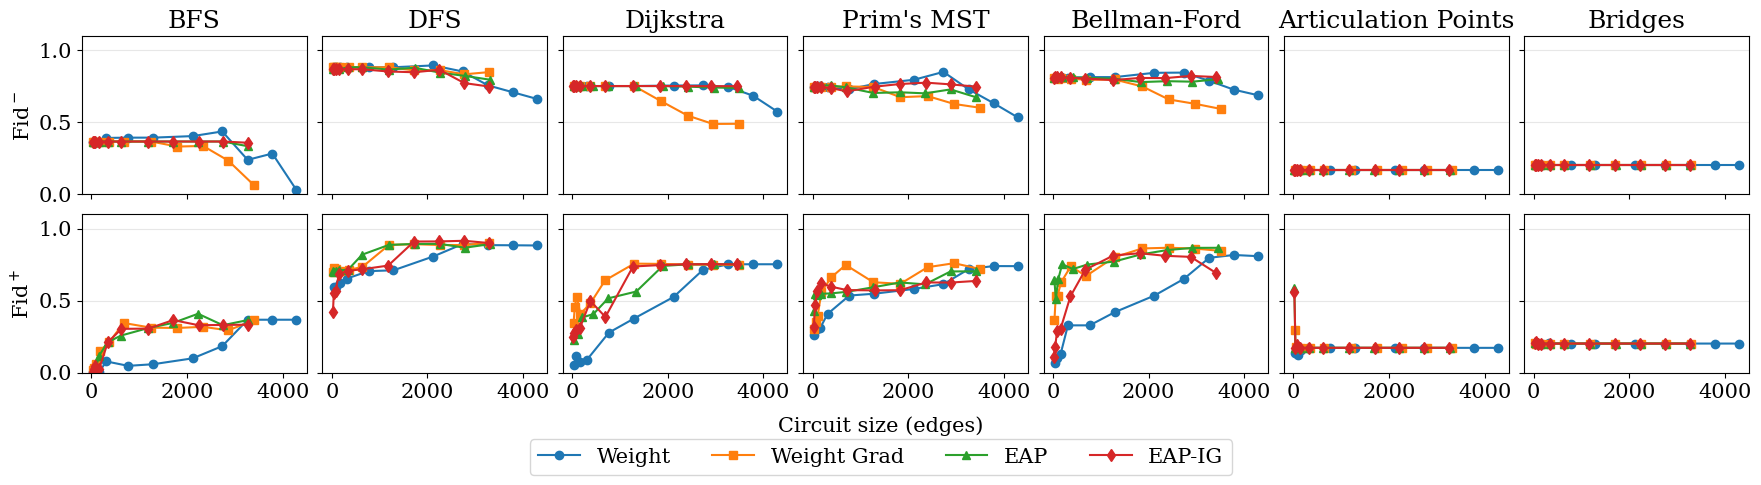

In [28]:
tasks = algorithms
Ks_list = Ks
cols = len(tasks)
rows = 2
score_methods_plotting = ['Weight', 'Weight Grad', 'EAP', 'EAP-IG']
score_markers = ['o', 's', '^', 'd']
fig, axes = plt.subplots(rows, cols, figsize=(2.5 * cols, 4), constrained_layout=True, sharex=True, sharey=True)
for i, task in enumerate(tasks):
    ax_c = axes[0][i]
    ax_a = axes[1][i]
    for score_method, score_plot, marker in zip(score_methods, score_methods_plotting, score_markers):
        x = [circuits[(task, K, score_method)].number_of_edges() for K in Ks_list]

        y_c = [float(fid_circuit.get((task, K, score_method), float('nan'))) for K in Ks_list]
        ax_c.plot(x, y_c, marker=marker, label=score_plot)
        y_a = [float(fid_ablate.get((task, K, score_method), float('nan'))) for K in Ks_list]
        ax_a.plot(x, y_a, marker=marker, label=score_plot)

    ax_c.set_title(algorithms_plotting[i])
    if i == 0:
        ax_c.set_ylabel(r'Fid$^-$')
        ax_a.set_ylabel(r'Fid$^+$')
    ax_c.grid(axis='y', alpha=0.3)
    ax_c.set_ylim(0, 1.1)
    ax_a.grid(axis='y', alpha=0.3)
    ax_a.set_ylim(0, 1.1)

fig.text(0.5, -0.05, 'Circuit size (edges)', ha='center', va='center')
fig.legend(score_methods_plotting, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -.2))
plt.savefig(f'figures/fidelity_circuit_ablate_vs_K_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/fidelity_circuit_ablate_vs_K_l1_lr={lr}_eta={eta}_weight_decay={weight_decay}.pdf', bbox_inches='tight')

In [29]:
def characterization_score(circuit_fid, ablate_fid, w_circuit=0.5, w_ablate=0.5):
    assert w_circuit + w_ablate == 1.0, "Weights must sum to 1."
    return 1 / (w_circuit / (1-circuit_fid) + w_ablate / ablate_fid)
circuit_char_scores = {}
for task in algorithms:
    for K in Ks:
        for score_method in score_methods:
            circuit_fid = fid_circuit.get((task, K, score_method))
            ablate_fid = fid_ablate.get((task, K, score_method))
            char_score = characterization_score(circuit_fid, ablate_fid)
            circuit_char_scores[(task, K, score_method)] = char_score

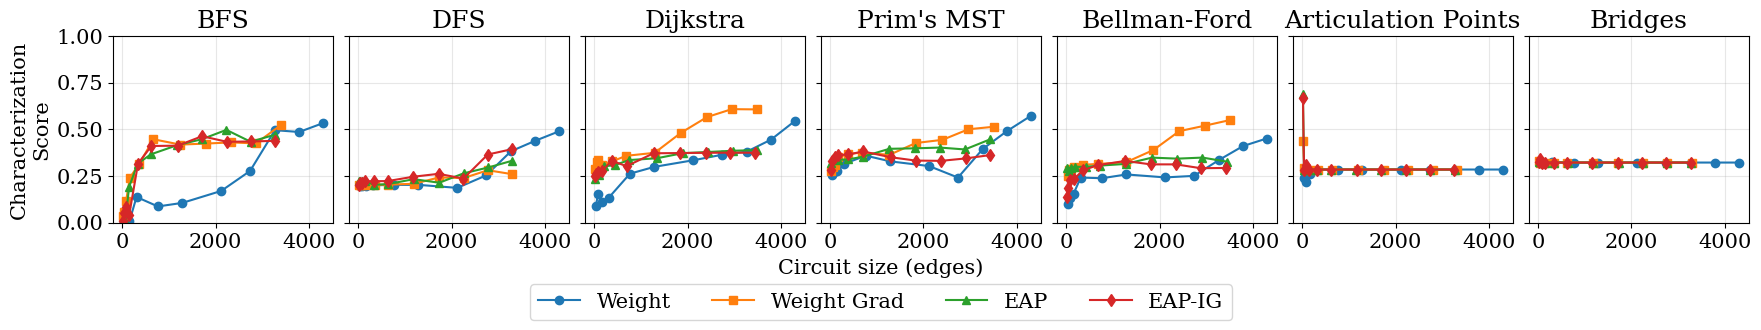

In [30]:
# Plot characterization scores vs circuit size for each task
tasks = algorithms
Ks_list = Ks
methods = score_methods
markers = score_markers[:len(methods)]
fig, axes = plt.subplots(1, len(tasks), figsize=(2.5 * len(tasks), 2.5), sharey=True, constrained_layout=True)

for i, task in enumerate(tasks):
    ax = axes[i] if len(tasks) > 1 else axes
    for method, method_plot, marker in zip(methods, score_methods_plotting, markers):
        xs = []
        ys = []
        for K in Ks_list:
            key = (task, K, method)
            if key in circuit_char_scores and (task, K, method) in circuits:
                try:
                    xs.append(circuits[(task, K, method)].number_of_edges())
                    ys.append(float(circuit_char_scores[key]))
                except Exception:
                    continue
        if xs:
            ax.plot(xs, ys, marker=marker, label=method_plot)
    ax.set_title(algorithms_plotting[i])
    if i == 0:
        ax.set_ylabel('Characterization\nScore')
    ax.grid(alpha=0.3)
    ax.set_ylim(0, 1)
    
fig.text(0.5, -0.05, 'Circuit size (edges)', ha='center', va='center')
fig.legend(score_methods_plotting, loc='lower center', ncol=len(methods), bbox_to_anchor=(0.5, -0.3))
plt.savefig(f'figures/characterization_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}.png', dpi=300, bbox_inches='tight')
plt.savefig(f'figures/characterization_scores_lr={lr}_eta={eta}_weight_decay={weight_decay}.pdf', bbox_inches='tight')
plt.show()